In [1]:
import casadi as ca
import sys
import numpy as np
from IPython.display import Image
import scipy.integrate
import matplotlib.pyplot as plt

from casadi.tools.graph import dotgraph

sys.path.insert(0, '../python/pyecca/')
from pyecca.lie import so3
from pyecca.util import rk4

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

$v = \dfrac{^e d}{dt} r$, where r is a position vector

$\dfrac{^ed}{dt} (mv) = F$ Newton's 2nd law. Derivative of linear momentum w.r.t. the inertial frame is equal to the force applied on a rigid body.

$^e\dfrac{d}{dt} (J ^e\omega^b) = M$ Newton's 2nd law (angular version). Derivative of the angular momentum w.r.t. the inertial frame is equal to the moment applied on the rigid body.

$\dot{m} v  + m \dfrac{^ed}{dt} (v) = F$

$\dot{m} v_e  + m \dfrac{^ed}{dt} (v_e) = F_e$

Simplifies to

$\dot{m} v_e  + m a_e = F_e$

Body frame:

$\dot{m} v_b  + m \dfrac{^ed}{dt} (v_b) = F_b$

$\dot{m} v_b  + m \left( \dfrac{^b d}{dt} (v_b) + ^e\omega^b \times v_b \right) = F_b$

$\dot{m} v_b  + m \left( \dot{v}_b + ^e\omega^b \times v_b \right) = F_b$

In the state vector, $\vec{x}$ we would have:

$v_b$: linear velocity, $^e\omega^b_b$: angular velocity, $m$: mass, $r$: position vector, and orientation, not clear which one we want.

## Choices for Orientation (3 Rotational degrees of freedom)

* Euler angles
    * Advantages:
        * 3 angles
    * Disadvantages:
        * Gimbal lock/ singularity
* Direction Cosine Matrix
    * Advantages:
        * No singularity.
        * Can just use matrix multiplication to rotate vectors.
    * Disadvantages:
        * 9 parameters
* Quaternions
    * Advantages:
        * No singularity.
    * Disadvantages:
        * 4 parameters, because there is a constraint of unit magnitude, so we have one extra parameter.
* Modified Rodrigues Parameters
    * Advantages:
        * Singularity, but can be avoided using the shadow parameter. 3 parameters and a shadow set. (3.5 parameters, because the last keeps track of if you are using the shadow set)
    * Disadvantages:
        * Has extra binary switch. Have to make sure switch doesn't impact control system.

These are all part of the SO(3) group in mathematics that describe 3D rotations.

In [2]:
def rocket_equations(jit=True):
    x = ca.SX.sym('x', 14)
    u = ca.SX.sym('u', 4)
    p = ca.SX.sym('p', 13)

    # State: x
    omega_b = x[0:3]  # inertial angular velocity expressed in body frame
    r_nb = x[3:7]  # modified rodrigues parameters
    v_b = x[7:10]  # inertial velocity expressed in body components
    p_n = x[10:13]  # positon in nav frame
    m = x[13]  # mass
    
    # Input: u    
    m_dot = ca.if_else(m > 0.2, u[0], 0)
    aileron = u[1]
    elevator = u[2]
    rudder = u[3]
    
    # Parameters: p
    g = p[0]  # gravity
    Jx = p[1]  # moment of inertia
    Jy = p[2]
    Jz = p[3]
    Jxz = p[4]
    ve = p[5]
    l_fin = p[6]
    CL_alpha = p[7]
    CL0 = p[8]
    CD0 = p[9]
    K = p[10]
    s = p[11]
    rho = p[12]
    
    # Calculations
    VT = ca.norm_2(v_b)
    J_b = ca.SX.zeros(3, 3)
    J_b[0, 0] = Jx
    J_b[1, 1] = Jy
    J_b[2, 2] = Jz
    J_b[0, 2] = J_b[2, 0] = Jxz
    C_nb = so3.Dcm.from_mrp(r_nb)
    g_n = ca.vertcat(0, 0, g)
    v_n = ca.mtimes(C_nb, v_b)
    q = 0.5*rho*VT**2
   
    # handle fin aerodynamics
    fins = {
        'top': {
            'fwd': [1, 0, 0],
            'up': [0, 1, 0],
            'mix': aileron + rudder,
        },
        'left': {
            'fwd': [1, 0, 0],
            'up': [0, 0, -1],
            'mix': aileron + elevator,
        },
        'down': {
            'fwd': [1, 0, 0],
            'up': [0, -1, 0],
            'mix': aileron - rudder,
        },
        'right': {
            'fwd': [1, 0, 0],
            'up': [0, 0, 1],
            'mix': aileron - elevator,
        },
    }
    FA_b = ca.SX.zeros(3)
    MA_b = ca.SX.zeros(3) 
    for key, data in fins.items():
        fwd = data['fwd']
        up = data['up']
        mix = data['mix']
        U = ca.dot(fwd, v_b)
        W = ca.dot(up, v_b)
        alpha = ca.if_else(
            ca.logic_and(ca.fabs(W) > 0.1, ca.fabs(U) > 0.1),
            -ca.atan(W/U), 0)
        CL = CL0 + CL_alpha*(alpha + mix)
        CD = CD0 + K*(CL - CL0)**2
        L = CL*q*s
        D = CD*q*s
        FA_b += L*up - D*fwd
        MA_b += ca.cross(ca.vertcat(-l_fin, 0, 0), FA_b)

    # propulsion
    FP_b = ca.vertcat(m_dot*ve, 0, 0)
    MP_b = ca.vertcat(0, 0, 0)
    
    # force and momental total
    F_b = FA_b + FP_b + ca.mtimes(C_nb.T, g_n)
    M_b = MA_b + MP_b
    
    rhs = ca.Function('rhs', [x, u, p], [ca.vertcat(
        ca.mtimes(ca.inv(J_b), M_b - ca.cross(omega_b, ca.mtimes(J_b, omega_b))),
        so3.Mrp.kinematics(r_nb, omega_b),
        F_b/m - m_dot*v_b/m - ca.cross(omega_b, v_b),
        ca.mtimes(C_nb, v_b), -m_dot)], ['x', 'u', 'p'], ['rhs'], {'jit': jit})

    # prediction
    t0 = ca.SX.sym('t0')
    h = ca.SX.sym('h')
    x0 = ca.SX.sym('x', 14)
    x1 = rk4(lambda t, x: rhs(x, u, p), t0, x0, h)
    x1[3:7] = so3.Mrp.shadow_if_necessary(x1[3:7])
    predict = ca.Function('predict', [x0, u, p, t0, h], [x1], {'jit': jit})

    return {
        'rhs': rhs,
        'predict': predict,
        'x': x,
        'u': u,
        'p': p,

    }
    return rhs, x, u, p

def initialize(pitch_deg):
    omega_b = ca.vertcat(0, 0, 0)
    r_nb = so3.Mrp.from_euler(ca.DM([0, np.deg2rad(pitch_deg), 0]))
    v_b = ca.vertcat(0, 0, 0)
    p_n = ca.vertcat(0, 0, 0)
    m = 1.0
    # x: omega_b, r_nb, v_b, p_n, m
    x0 = np.array(ca.DM(ca.vertcat(omega_b, r_nb, v_b, p_n, m)), dtype=float).reshape(-1)
    
    #      g, Jx, Jy, Jz, Jxz, ve, l_fin, CL_alpha, CL0, CD0, K, s, rho
    p0 = np.array([9.8, 1, 1, 1, 0.1, 350, 1.0, 2*np.pi, 0, 0.01, 0.1, 0.01, 1.225])
    return x0, p0

In [3]:
def analyze_data(data):
    plt.figure()
    plt.title('fuel')
    plt.plot(data['t'], data['x'][:, 13])
    plt.xlabel('t, sec')
    plt.ylabel('mass, kg')
    plt.grid()

    plt.figure()
    plt.title('velocity')
    plt.plot(data['t'], data['x'][:, 7], label='v_X')
    plt.plot(data['t'], data['x'][:, 8], label='v_Y')
    plt.plot(data['t'], data['x'][:, 9], label='v_Z')
    plt.grid()
    plt.legend()
    
    plt.figure()
    euler = np.array(
        [np.array(ca.DM(so3.Euler.from_mrp(x))).reshape(-1) for x in data['x'][:, 3:7]])
    plt.plot(data['t'], np.rad2deg(euler[:, 0]), label='roll')
    plt.plot(data['t'], np.rad2deg(euler[:, 1]), label='pitch')
    plt.plot(data['t'], np.rad2deg(euler[:, 2]), label='yaw')
    plt.legend()
    plt.grid()
    plt.title('euler')
    
    plt.figure()
    plt.title('trajectory [side]')
    plt.plot(data['x'][:, 10], -data['x'][:, 12])
    plt.xlabel('North, m')
    plt.ylabel('Altitude, m')
    plt.axis('equal')
    plt.grid()
    
    plt.figure()
    plt.title('trajectory [top]')
    plt.plot(data['x'][:, 11], data['x'][:, 10])
    plt.xlabel('East, m')
    plt.ylabel('North, m')
    plt.axis('equal')
    plt.grid()

In [4]:
def simulate(rocket, x0, u0, p0, dt=0.01, t0=0, tf=10):
    """
    An integrator using a fixed step runge-kutta approach.
    """
    x = x0
    data = {
        't': [],
        'x': []
    }
    for t in np.arange(t0, tf, dt):
        data['x'].append(np.array(x).reshape(-1))
        data['t'].append(t)
        x = rocket['predict'](x, u0, p0, t, dt)
   
    for k in data.keys():
        data[k] = np.array(data[k])
    return data

CPU times: user 1.68 s, sys: 20.2 ms, total: 1.7 s
Wall time: 1.68 s


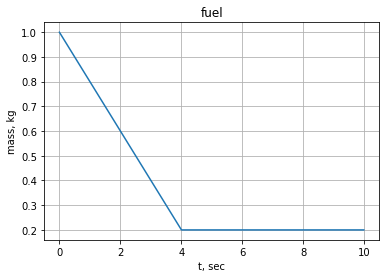

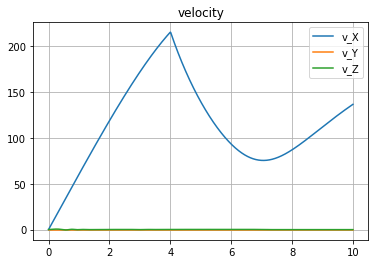

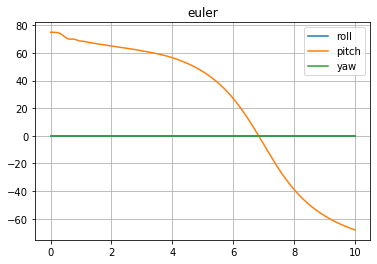

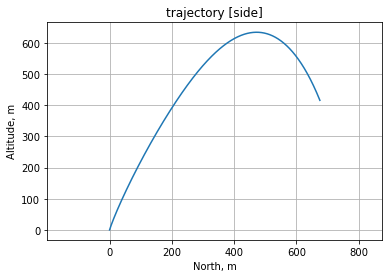

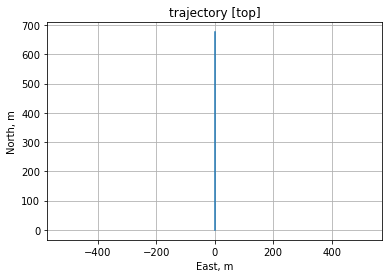

In [5]:
%%time
x0, p0 = initialize(pitch_deg=75)
# m_dot, aileron, elevator, rudder
u0 = [0.2, 0, 0, 0]
rocket = rocket_equations()
data = simulate(rocket, x0, u0, p0, tf=10)
analyze_data(data)

In [6]:
def simulate_scipy(rocket, x0, u0, p0, dt=0.01, t0=0, tf=10):
    """
    An integrator using a variable step size approach.
    """
    res = scipy.integrate.solve_ivp(
        fun=lambda t, x: np.array(rocket['rhs'](x, u0, p0)).reshape(-1),
        t_span=[t0, tf], y0=x0, t_eval=np.arange(t0, tf, dt))
    if not res['success']:
        raise ValueError(res['message'])
    return {
        't': res['t'],
        'x': res['y'].T
    }

CPU times: user 3.12 s, sys: 12 ms, total: 3.13 s
Wall time: 3.09 s


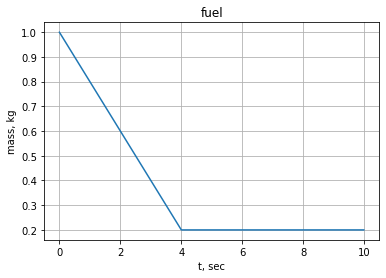

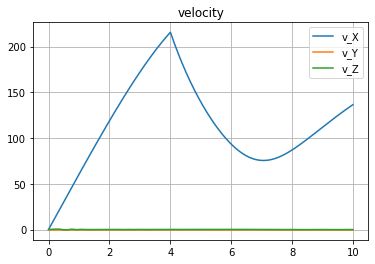

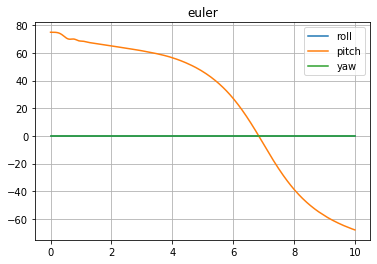

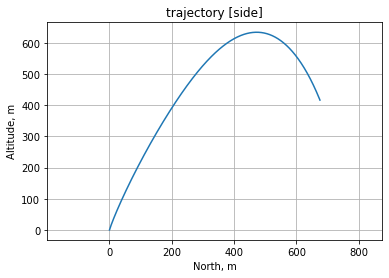

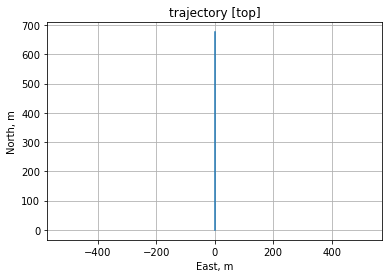

In [7]:
%%time
x0, p0 = initialize(pitch_deg=75)
# m_dot, aileron, elevator, rudder
u0 = [0.2, 0, 0, 0]
rocket = rocket_equations()
data2 = simulate_scipy(rocket, x0, u0, p0)
analyze_data(data2)